# Homework 2

Author: Noah Hicks

Date: 09-30-2025

Net ID: nhicks

Note: In-line autocomplete done with GPT-5 within Cursor. Author approves and takes responsibility for all work.

## Monte Carlo Tree Search for 4x4 Tic-Tac-Toe

This notebook implements a 4x4 Tic-Tac-Toe game engine and Monte Carlo Tree Search (MCTS)
to compare random play versus MCTS-guided play, as required for 95-891 Introduction to AI HW2.

Project:
- Implement a 4x4 Tic-Tac-Toe engine with move, undo, and winner detection.
- Implement MCTS (with UCT) for move selection.
- Run experiments: Random vs Random, MCTS vs Random, and sweep UCT exploration weight C.
- Report win rates for X (first player) using the scoring: win=1.0, draw=0.5, loss=0.0.
- All code and results are in this notebook.

## Contents

1. Setup
2. Game Engine: TicTacToe4x4
3. MCTS Node
4. MCTS Search
5. Experiments
   - Random vs Random baseline
   - MCTS (X) vs Random (O)
   - Sweep exploration weight C
6. Answers


## Setup

This notebook implements 4x4 Tic-Tac-Toe and Monte Carlo Tree Search (MCTS) experiments. 


In [23]:
import numpy as np
import random
import math
from typing import List, Optional, Tuple

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)



## Game Engine: TicTacToe4x4


In [24]:
class TicTacToe4x4:
    """4x4 Tic-Tac-Toe environment.

    State:
        - board: 4x4 list of str; values in {' ', 'X', 'O'}
        - current_player: 'X' or 'O' (X starts)

    Scoring/reporting is from X's perspective.
    """

    def __init__(self):
        self.size = 4
        self.board = [[' ' for _ in range(self.size)] for _ in range(self.size)]
        self.current_player = 'X'

    def clone(self) -> 'TicTacToe4x4':
        clone = TicTacToe4x4()
        clone.board = [row[:] for row in self.board]
        clone.current_player = self.current_player
        return clone

    def available_moves(self) -> List[Tuple[int, int]]:
        moves = []
        for r in range(self.size):
            for c in range(self.size):
                if self.board[r][c] == ' ':
                    moves.append((r, c))
        return moves

    def make_move(self, move: Tuple[int, int]) -> None:
        r, c = move
        if self.board[r][c] != ' ':
            raise ValueError("Invalid move: cell not empty")
        self.board[r][c] = self.current_player
        self.current_player = 'O' if self.current_player == 'X' else 'X'

    def undo_move(self, move: Tuple[int, int]) -> None:
        r, c = move
        if self.board[r][c] == ' ':
            raise ValueError("Invalid undo: cell already empty")
        self.board[r][c] = ' '
        self.current_player = 'O' if self.current_player == 'X' else 'X'

    def check_winner(self) -> Optional[str]:
        # Rows and columns
        lines = []
        lines.extend(self.board)
        lines.extend([[self.board[r][c] for r in range(self.size)] for c in range(self.size)])
        # Diagonals
        lines.append([self.board[i][i] for i in range(self.size)])
        lines.append([self.board[i][self.size - 1 - i] for i in range(self.size)])
        for line in lines:
            if all(cell == 'X' for cell in line):
                return 'X'
            if all(cell == 'O' for cell in line):
                return 'O'
        # Draw if no empty spaces and no winner
        if all(self.board[r][c] != ' ' for r in range(self.size) for c in range(self.size)):
            return 'Draw'
        return None

    def is_terminal(self) -> bool:
        return self.check_winner() is not None

    def score_from_x_perspective(self) -> float:
        winner = self.check_winner()
        if winner == 'X':
            return 1.0
        if winner == 'O':
            return 0.0
        if winner == 'Draw':
            return 0.5
        return 0.0  # Non-terminal; callers should not request score prematurely



## MCTS Node


In [25]:
class MCTSNode:
    """Node for MCTS.

    Tracks visits and cumulative value from X's perspective.
    """

    def __init__(self, state: TicTacToe4x4, parent: Optional['MCTSNode'] = None, move: Optional[Tuple[int, int]] = None):
        self.state = state
        self.parent = parent
        self.move = move
        self.children = {}
        self.untried_moves = state.available_moves()
        random.shuffle(self.untried_moves)
        self.visits = 0
        self.value = 0.0  # cumulative reward from X perspective

    def is_fully_expanded(self) -> bool:
        return len(self.untried_moves) == 0

    def expand(self) -> 'MCTSNode':
        move = self.untried_moves.pop()
        next_state = self.state.clone()
        next_state.make_move(move)
        child = MCTSNode(next_state, parent=self, move=move)
        self.children[move] = child
        return child

    def best_child(self, exploration_weight: float) -> 'MCTSNode':
        assert self.visits > 0, "Parent must have been visited before selecting best child"
        best_score = -float('inf')
        best = None
        for move, child in self.children.items():
            if child.visits == 0:
                uct = float('inf')
            else:
                avg_value = child.value / child.visits
                # Convert X-perspective value to current player's perspective at this node
                if self.state.current_player == 'X':
                    exploitation = avg_value
                else:
                    exploitation = 1.0 - avg_value
                uct = exploitation + exploration_weight * math.sqrt(math.log(self.visits) / child.visits)
            if uct > best_score:
                best_score = uct
                best = child
        return best



## MCTS Search


In [26]:
class MCTS:
    """Monte Carlo Tree Search with UCT selection."""

    def __init__(self, itermax: int = 1000, exploration_weight: float = 1.4):
        self.itermax = itermax
        self.exploration_weight = exploration_weight

    def search(self, root_state: TicTacToe4x4) -> Tuple[int, int]:
        root = MCTSNode(root_state.clone())
        for _ in range(self.itermax):
            node = self._select(root)
            result = self._simulate(node.state.clone())
            self._backpropagate(node, result)
        # Choose the child with highest average value (exploitation only)
        best_move = None
        best_avg = -float('inf')
        for move, child in root.children.items():
            if child.visits == 0:
                continue
            avg = child.value / child.visits
            if avg > best_avg:
                best_avg = avg
                best_move = move
        if best_move is None:
            # fallback to any available move
            moves = root_state.available_moves()
            return random.choice(moves)
        return best_move

    def _select(self, node: MCTSNode) -> MCTSNode:
        while not node.state.is_terminal():
            if not node.is_fully_expanded():
                return node.expand()
            else:
                node = node.best_child(self.exploration_weight)
        return node

    def _simulate(self, state: TicTacToe4x4) -> float:
        # Random rollout until terminal; return score from X's perspective
        while not state.is_terminal():
            moves = state.available_moves()
            move = random.choice(moves)
            state.make_move(move)
        return state.score_from_x_perspective()

    def _backpropagate(self, node: MCTSNode, result: float) -> None:
        while node is not None:
            node.visits += 1
            node.value += result
            node = node.parent



## Experiments

### Random vs Random baseline

In [27]:
def play_random_vs_random(n_games: int, seed: int = 42) -> float:
    random.seed(seed)
    np.random.seed(seed)
    total_score = 0.0
    for _ in range(n_games):
        env = TicTacToe4x4()
        while not env.is_terminal():
            move = random.choice(env.available_moves())
            env.make_move(move)
        total_score += env.score_from_x_perspective()
    return total_score / n_games

# Quick smoke test for baseline
baseline_avg = play_random_vs_random(50, seed=RANDOM_SEED)
baseline_avg


0.54

### MCTS (X) vs Random (O)

In [28]:
def play_mcts_vs_random(n_games: int, itermax: int, C: float, seed: int = 42) -> float:
    random.seed(seed)
    np.random.seed(seed)
    total_score = 0.0
    for _ in range(n_games):
        env = TicTacToe4x4()
        mcts = MCTS(itermax=itermax, exploration_weight=C)
        while not env.is_terminal():
            if env.current_player == 'X':
                move = mcts.search(env)
            else:
                move = random.choice(env.available_moves())
            env.make_move(move)
        total_score += env.score_from_x_perspective()
    return total_score / n_games

# Quick smoke test for MCTS vs Random
mcts_avg = play_mcts_vs_random(n_games=50, itermax=400, C=1.4, seed=RANDOM_SEED)
mcts_avg


1.0

### Sweep exploration weight C

(0.5, 0.9925)

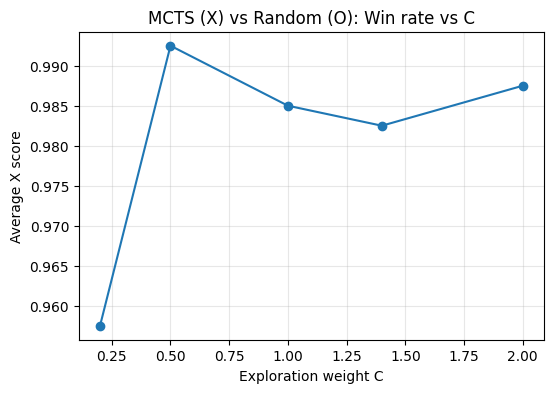

In [29]:
import matplotlib.pyplot as plt

def sweep_C_and_plot(C_values, n_games: int, itermax: int, seed: int = 42):
    results = []
    for C in C_values:
        avg = play_mcts_vs_random(n_games=n_games, itermax=itermax, C=C, seed=seed)
        results.append(avg)
    plt.figure(figsize=(6,4))
    plt.plot(C_values, results, marker='o')
    plt.xlabel('Exploration weight C')
    plt.ylabel('Average X score')
    plt.title('MCTS (X) vs Random (O): Win rate vs C')
    plt.grid(True, alpha=0.3)
    best_idx = int(np.argmax(results))
    best_C = C_values[best_idx]
    best_avg = results[best_idx]
    return C_values, results, best_C, best_avg

# Quick smoke test
C_values = [0.2, 0.5, 1.0, 1.4, 2.0]
C_values, results, best_C, best_avg = sweep_C_and_plot(C_values, n_games=200, itermax=300, seed=RANDOM_SEED)
(best_C, best_avg)


## Answers

1. We expect the average win rate of the first player to be about .5, which is shown by our random evaluation above. 
2. MCTS shows a much higher score against the random opponent. At a C value above .5 up to 2, the average win rate stays above 98%, which is higher than the 50% random results.
3. The best C seems to be .5 from my testing. 
